# Week 5 - Data Understanding and Preparation (Part 3)

## Notes

In [31]:
# Clear the workspace
rm(list=ls())

# Load the relevant packages
library('gapminder')
library('tidyverse')
library('gridExtra')

# This is from the actual Google sheets
gapminderall <- read_csv('data/Case Study 1 - Gapminder/gapminderall.csv', col_types=cols())

# This is from the R library
data(gapminder)

### Checking Validity

One way we can check the validity of data is to check between two sources. In the case of the gapminder data, we can use:
* `setdiff()` which lists the actual differences based on the object called first.
* `setequal()` which returns TRUE if the two objects are equal.

In [2]:
setdiff(unique(gapminder$country), unique(gapminderall$country))

[1] "Afghanistan"           "Korea, Dem. Rep."      "Myanmar"              
[4] "Reunion"               "Sao Tome and Principe" "Somalia"              
[7] "Taiwan"

### Duplicates

We can remove duplicates easily with the `distinct()` function. In the gapminder data set, all rows are distinct.

In [3]:
print(dim(gapminderall))
print(dim(distinct(gapminderall)))

[1] 10545     9
[1] 10545     9


### Missing Values

It is important to consider the underlying reasons for why there is missing data. Missing data can create major risk of producing incorrect conclusions due to absence of relevant information leading to invalid results.

Missing data are typically grouped into three categories. This [website](https://www-users.york.ac.uk/~mb55/intro/typemiss4.htm) provides an awesome explanation. This [too](https://stefvanbuuren.name/fimd/sec-MCAR.html).
* **Missing completely at random** (MCAR)
    * The missing data is independent of the observed and unobserved data and occur *entirely at random*.
    * That is, the missingness has nothing to do with the person being studied.
    * In other words, the data which remains can be considered a simple random sample of the full data set.
    * For example, a questionnaire might get lost.
    * This is generally regarded as a strong and often unrealistic assumption.
* **Missing at random** (MAR)
    * The missing data is systematically related to the observed but not the unobserved data.
    * That is, the missingness has to do with the person, but can be predicted from other information about the person.
    * This is easiest explained with an example. Consider that a survey is being conducted on depression. Male participants are less likely to complete the survey than female participants. So, the cause of the missing data is due to gender (observed) rather than their level of depression (unobserved).
    * MAR is more general and more realistic than MCAR. Hence modern missing data methods generally start from the MAR assumption.
* **Missing not at random** (MNAR)
    * The missing data is systematically related to the unobserved data.
    * If neither MCAR or MAR hold, then we consider MNAR.
    * Continuing on from the previous example of a survey being conducted on depression. The missing data is considered MNAR if participants fail to complete the survey because of their level of depression (unobserved).

And to handle missing values we can:
* **Do nothing** - While some R functions will automatically omit NAs, others will fail and produce an error.
* **Omit all observations with NAs** - In large datasets, this could be a consideration, but there's also the risk of losing information.
* **Impute values** - This could include:
    * Substituting NAs with 0.
    * Substituting with the mean, median or mode value.
    * Creating a custom algorithm to impute the values.

#### Summarising Missing Values

Before we can handle missing values, we must understand and explore where the missing values occur. We can do this with the `naniar` package which provides many ways to summarise missing data or `sapply()` in base R.

In [4]:
library('naniar')
miss_var_summary(gapminderall)

variable,n_miss,pct_miss
gdp,2755,26.126126
infant_mortality,1453,13.779042
fertility,187,1.773352
population,185,1.754386
country,0,0.000000
year,0,0.000000
life_expectancy,0,0.000000
continent,0,0.000000
region,0,0.000000


In [5]:
sapply(gapminderall, function(x){(sum(is.na(x)))})

country             year infant_mortality  life_expectancy 
               0                0             1453                0 
       fertility       population              gdp        continent 
             187              185             2755                0 
          region 
               0

#### Imputing

Once we have an idea of the missing data, we can impute using either:
* The `dplyr` package and `ifelse()`.
* The `naniar` and `simputation` packages.

Using `dplyr` and `ifelse()`, we change the missing values to 0 in the first example, and the mean value in the second example. Note that `na.rm=TRUE` ignores NAs in the calculation of the mean.

In [6]:
gapminder_zero <- gapminderall %>%
    mutate(
        infant_mortality=ifelse(is.na(infant_mortality), 0, infant_mortality),
        fertility=ifelse(is.na(fertility), 0, fertility),
        population=ifelse(is.na(population), 0, population),
        gdp=ifelse(is.na(gdp), 0, gdp),
    )
head(gapminder_zero, 3)
# miss_var_summary(gapminder_zero)

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region
Albania,1960,115.4,62.87,6.19,1636054,0,Europe,Southern Europe
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa
Angola,1960,208.0,35.98,7.32,5270844,0,Africa,Middle Africa


In [7]:
gapminder_mean <- gapminderall %>%
    mutate(
        infant_mortality=ifelse(is.na(infant_mortality), mean(infant_mortality, na.rm=TRUE), infant_mortality),
        fertility=ifelse(is.na(fertility), mean(fertility, na.rm=TRUE), fertility),
        population=ifelse(is.na(population), mean(population, na.rm=TRUE), population),
        gdp=ifelse(is.na(gdp), mean(gdp, na.rm=TRUE), gdp),
    )
head(gapminder_mean, 3)
# miss_var_summary(gapminder_mean)

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region
Albania,1960,115.4,62.87,6.19,1636054,155913472931,Europe,Southern Europe
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa
Angola,1960,208.0,35.98,7.32,5270844,155913472931,Africa,Middle Africa


Using `naniar` and `simputation`,

In [8]:
library('naniar')
library('simputation')

Warning message:
"package 'simputation' was built under R version 3.6.3"
Attaching package: 'simputation'

The following object is masked from 'package:naniar':

    impute_median



**Replacing all NAs with zeros**

Let's go through each function of code below:
* `bind_shadow(only_miss=TRUE)` creates a column called 'col_NA' only for columns with missing values.
* `add_label_shadow()` creates a column called 'any_missing' which is pretty self-explanatory.
* `impute_const(col~0)` imputes zeros into that column.

In [9]:
gap_zero <- gapminderall %>%
    bind_shadow(only_miss=TRUE) %>%
    add_label_shadow() %>%
    impute_const(fertility~0) %>%
    impute_const(population~0) %>%
    impute_const(infant_mortality~0) %>%
    impute_const(gdp~0)
head(gap_zero, 3)
# miss_var_summary(gap_zero)

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region,infant_mortality_NA,fertility_NA,population_NA,gdp_NA,any_missing
Albania,1960,115.4,62.87,6.19,1636054,0,Europe,Southern Europe,!NA,!NA,!NA,NA,Missing
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa,!NA,!NA,!NA,!NA,Not Missing
Angola,1960,208.0,35.98,7.32,5270844,0,Africa,Middle Africa,!NA,!NA,!NA,NA,Missing


**Replacing all NAs with mean**

In [10]:
gap_mean <- gapminderall %>%
    impute_mean_all()
head(gap_mean, 3)
# miss_var_summary(gap_mean)

Warning message in mean.default(x, na.rm = TRUE):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = TRUE):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = TRUE):
"argument is not numeric or logical: returning NA"

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region
Albania,1960,115.4,62.87,6.19,1636054,155913472931,Europe,Southern Europe
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa
Angola,1960,208.0,35.98,7.32,5270844,155913472931,Africa,Middle Africa


#### Replacing all NAs with median

In [11]:
gap_median <- gapminderall %>%
    impute_median_all()
head(gap_median, 3)

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region
Albania,1960,115.4,62.87,6.19,1636054,9498095348,Europe,Southern Europe
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa
Angola,1960,208.0,35.98,7.32,5270844,9498095348,Africa,Middle Africa


#### Replacing all NAs with linear imputation

We do this with the `simputation` package.

In [12]:
gap_lm <- gapminderall %>%
    bind_shadow(only_miss=TRUE) %>%
    add_label_shadow() %>%
    impute_lm(fertility ~ life_expectancy) %>%
    impute_lm(population ~ life_expectancy + fertility + year) %>%
    impute_lm(infant_mortality ~ life_expectancy + fertility) %>%
    impute_lm(gdp ~ life_expectancy + year)
head(gap_lm, 3)

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region,infant_mortality_NA,fertility_NA,population_NA,gdp_NA,any_missing
Albania,1960,115.4,62.87,6.19,1636054,163717886350,Europe,Southern Europe,!NA,!NA,!NA,NA,Missing
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa,!NA,!NA,!NA,!NA,Not Missing
Angola,1960,208.0,35.98,7.32,5270844,-218486732820,Africa,Middle Africa,!NA,!NA,!NA,NA,Missing


### Outliers

The options to deal with outliers is similar to that of missing values:
* **Keep the outlier**
* **Drop the outlier** - Using `filter()`
* **Cap the outlier** - Using `mutate()` and `ifelse()`; or `pmin()` or `pmax()`
* **Impute the outlier** - Using `mutate()` and `ifelse()` to impute the mean / median

### Correlation Considerations

> "Correlation does not imply causation" - Dr. Herbert West

These include:
* **Spurious correlation** - This is when two variables are statistically related but not directly causally related. We have to be careful not to over-interpret associations between variables.
* **Outliers** - Correlations can sometimes be driven by a few outliers. It is important to identify outliers when exploring the data.
* **Confounders** - Confounding occurs when an extraneous $x$ variable that is not of direct interest to the study has an influence on the response $y$ and must therefore be taken into account or controlled for. If not, incorrect results may be obtained.
    * Note that, as you include more variables, you lessen the bias but run the risk of introducing confounding variables. This will cause collinearity which increases the variance and reduces the precision of the estimates.
    * There is no formal statistical test to determine if confounding has occurred. We need to use judgement in conjunction with graphical evidence to make an informed decision.
    * For a small number of confounders, we could use stratification which is a method of sampling from a population which can be partitioned into subpopulations.
    * For large number of confounders, regression modelling allows the analysis to control for them.
* **Simpson's Paradox** - This is when the sign of the correlation flips when comparing the entire population and specific subsets of the population. It is most easily explained with an example, see the visual below. For the entire population (males and females), the correlation is positive. However, once we subset the population by gender, the correlations within each subset is negative.

<img src='https://www.researchgate.net/profile/Rogier-Kievit/publication/256074671/figure/fig1/AS:203083998076929@1425430406422/Example-of-Simpsons-Paradox-Despite-the-fact-that-there-exists-a-negative-relationship.png' width=50% />

#### Outliers

Looking at outliers a bit more closesly, let's create a hundred values each from $N(100,1)$ and $N(80,1)$, and standardise all values except the 10th value such that they now come from the $N(0,1)$ distribution. We plot the two vectors to see for easier reference

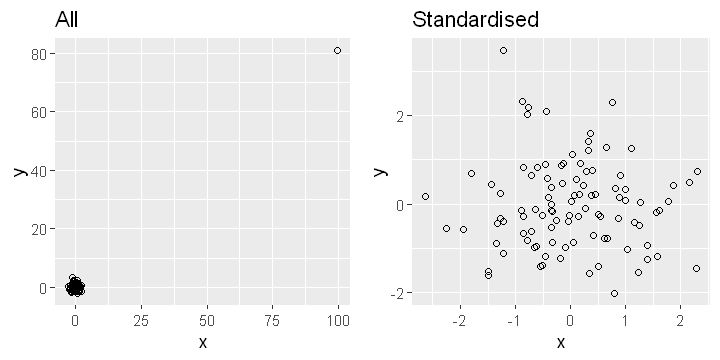

In [13]:
set.seed(123)
x <- rnorm(100, 100, 1) # 100 values from X ~ N(100, 1)
y <- rnorm(100, 80, 1) # 100 values from Y ~ N(80, 1)

# Standardising every value except the 10th value
x[-10] <- scale(x)[-10]
y[-10] <- scale(y)[-10]
temp <- data.frame(cbind(x, y))

options(repr.plot.width = 6, repr.plot.height = 3)
all <- temp %>%
    ggplot(aes(x, y)) +
    geom_point(shape=21) +
    ggtitle('All')
standardised <- temp[-10,] %>%
    ggplot(aes(x, y)) +
    geom_point(shape=21) +
    ggtitle('Standardised')
grid.arrange(all, standardised, ncol=2)

In [14]:
print(round(cor(x, y),2))
print(round(cor(x[-10], y[-10]),2))

[1] 0.99
[1] -0.04


Now, let's take a look at the two sets of correlations above:
* If we include all values, the correlation is: 0.99
* If we include only the standardised values, the correlation is: -0.04

This shows that the correlation is clearly **driven by the outlier**. Without the outlier, the values are almost perfectly uncorrelated. This is precisely the reason we need to be weary of outliers and be sure to identify them when exploring the data.

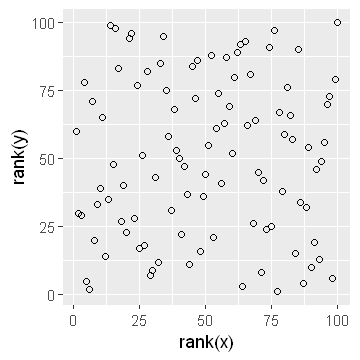

In [15]:
options(repr.plot.width = 3, repr.plot.height = 3)
temp %>%
    ggplot(aes(rank(x), rank(y))) +
    geom_point(shape=21)

### Variable / Feature Engineering

Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

Some examples of issues concerning variables / features including when we have:

| Issue | Solution
| :---- | :-------
| A categorical variable that has been encoded as a numeric variable. | We can recode variables as factors using the base R function: `factor(vector, order=TRUE, levels=c(...))` or `as.factor(vector)`
| Factors with levels that are counted differently but should be the same. | As R is case-sensitive, male vs MALE will be counted separately. We can inspect the data using `table()`, then `mutate()` a new column that resolves the discrepancy.
| Algorithms (such as logistic regression and support vector machines) unable to handle categorical variables | We convert the variable to $n$ dummy numerical variables, with each variable taking a value of 0 or 1. This is called **[one-hot encoding](#one-hot)**.<br><br>Meanwhile, in regression, one variable is treated as the *reference category* (think back to STAT3175). This means that the variable does not need to be encoded. This is called **dummy encoding**.<img src='https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F5315434%2Fa9886ea90db74aad0b2f86d2686c337b%2Fohe-vs-dummy.png?generation=1601465979026694&alt=media' width=80%>
| Categorical variables with high cardinality | Variables with high cardinality add complexity to the model, can lead to overfitting, and is taxing on computing resources. For example, post codes have high cardinality. That level of granularity may not be needed, and so post codes can be grouped to regions to reduce the complexity of the model.<br><br>Another popular method is called **[binning encoding](#binning)**. This involves combining classes for both nominal and ordinal categorical variables that are similar. After binning, one-hot encoding can be used to transform the categorical variables to dummy variables with values of 1 or 0.
| High number of features/variables in the dataset | This is similar to the high cardinality issue above. When we have a high number of features/variables in the dataset, we may end up with issues such as mediocre performance, long training times, and overfitting. Some ways to reduce complexity by removing variables are: Dimension reduction techniques such as **[principal component analysis](#pca)** (PCA), domain knowledge, **[subset selection](#subset-selection)**, and **[shrinkage techniques](#shrinkage)**.


<!-- https://miro.medium.com/max/1400/1*ggtP4a5YaRx6l09KQaYOnw.png -->

#### One-hot Encoding <a class='anchor' id='one-hot'></a>

Here's an example of how we can apply one-hot encoding - using `mutate()` and `ifelse()` - to the 'continent' column in gapminder:

In [16]:
gap_oneHot <- gapminderall %>%
    mutate(Europe = ifelse(continent=='Europe', 1, 0)) %>%
    mutate(Africa = ifelse(continent=='Africa', 1, 0)) %>%
    mutate(Americas = ifelse(continent=='Americas', 1, 0)) %>%
    mutate(Asia = ifelse(continent=='Asia', 1, 0)) %>%
    mutate(Oceania = ifelse(continent=='Oceania', 1, 0))
head(gap_oneHot, 3)

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region,Europe,Africa,Americas,Asia,Oceania
Albania,1960,115.4,62.87,6.19,1636054,NA,Europe,Southern Europe,1,0,0,0,0
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa,0,1,0,0,0
Angola,1960,208.0,35.98,7.32,5270844,NA,Africa,Middle Africa,0,1,0,0,0


#### Binning Encoding <a class='anchor' id='binning'></a>

Here's an example of how we can apply binning encoding - using `mutate()` and `case_when()`. But first, let's take a look at the different regions using `unique(gapminderall$country)`, then group them by a higher-level, that is, by continent.

In [17]:
Europe <- c('Southern Europe', 'Eastern Europe', 'Western Europe', 'Northern Europe')
Africa <- c('Northern Africa', 'Middle Africa', 'Western Africa', 'Southern Africa', 'Eastern Africa')
Americas <- c('South America', 'Central America', 'Northern America', 'Caribbean')
Asia <- c('Western Asia', 'Southern Asia', 'South-Eastern Asia', 'Eastern Asia', 'Central Asia')
Oceania <- c('Australia and New Zealand', 'Melanesia', 'Polynesia', 'Micronesia')

gapminder_group <- gapminderall %>%
    mutate(continent_new = case_when(region %in% Europe ~ 'Europe',
                                     region %in% Africa ~ 'Africa',
                                     region %in% Americas ~ 'Americas',
                                     region %in% Asia ~ 'Asia',
                                     region %in% Oceania ~ 'Oceania')) %>%
    select(continent, region, continent_new)

head(gapminder_group, 3)

continent,region,continent_new
Europe,Southern Europe,Europe
Africa,Northern Africa,Africa
Africa,Middle Africa,Africa


This example is quite neat in that we have a general idea of how regions are 'binned' into continents. However, say that we did not know how to group regions into continents. We could try to group using a **data driven method**. For example, we could use life expectancy as the deciding factor for grouping regions. This is how we would do that:

1. Split `life_expectancy` into ranges of 0-50 years, and 50+ years.

In [18]:
gapminder_lifegroup <- gapminderall %>%
    mutate(lifeExpRange = case_when(life_expectancy <= 50 ~ 'life50under',
                                    life_expectancy > 50 ~ 'life50over'))
head(gapminder_lifegroup, 3)

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region,lifeExpRange
Albania,1960,115.4,62.87,6.19,1636054,NA,Europe,Southern Europe,life50over
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa,life50under
Angola,1960,208.0,35.98,7.32,5270844,NA,Africa,Middle Africa,life50under


2. Create a proportion table of the frequencies between `region` and `lifeExpRange`, and convert it to a tibble.

In [19]:
prop_table <- gapminder_lifegroup %>%
    select(region, lifeExpRange) %>%
    table() %>%
    prop.table(1)
prop_tibble <- as_tibble(prop_table)
head(prop_tibble, 3)

region,lifeExpRange,n
Australia and New Zealand,life50over,1.0000000
Caribbean,life50over,0.9730094
Central America,life50over,0.9758772


3. Filter the rows where `lifeExpRange=='life50over` and rename `n` to `proportion`.

In [20]:
prop_tibble2 <- prop_tibble %>%
    filter(lifeExpRange == 'life50over') %>%
    rename(proportion=n)
head(prop_tibble2, 3)

region,lifeExpRange,proportion
Australia and New Zealand,life50over,1.0000000
Caribbean,life50over,0.9730094
Central America,life50over,0.9758772


4. Join the proportion tibble (prop_tibble2) with the original data set (gapminderall).

In [21]:
gapminderall_lifegroup <- left_join(gapminderall, prop_tibble2, by='region')
head(gapminderall_lifegroup, 3)

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region,lifeExpRange,proportion
Albania,1960,115.4,62.87,6.19,1636054,NA,Europe,Southern Europe,life50over,1.0000000
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa,life50over,0.9181287
Angola,1960,208.0,35.98,7.32,5270844,NA,Africa,Middle Africa,life50over,0.5570175


5. Create a new column with three levels of life expectancy (LE):
* Low LE: < 60%
* Mid LE: 60% - 80%
* High LE: > 80%

In [22]:
gapminderall_lifegroup <- gapminderall_lifegroup %>%
    mutate(regionGroups = case_when(proportion<0.6 ~ 'lowLE',
                                    proportion>=0.6 & proportion<0.8 ~ 'midLE',
                                    proportion>=0.8 ~ 'highLE'))
head(gapminderall_lifegroup, 3)

country,year,infant_mortality,life_expectancy,fertility,population,gdp,continent,region,lifeExpRange,proportion,regionGroups
Albania,1960,115.4,62.87,6.19,1636054,NA,Europe,Southern Europe,life50over,1.0000000,highLE
Algeria,1960,148.2,47.50,7.65,11124892,13828152297,Africa,Northern Africa,life50over,0.9181287,highLE
Angola,1960,208.0,35.98,7.32,5270844,NA,Africa,Middle Africa,life50over,0.5570175,lowLE


6. Finally, we can one-hot encode this.

In [23]:
gapminderall_lifegroup <- gapminderall_lifegroup %>%
    mutate(lowLE = ifelse(regionGroups=='lowLE', 1, 0)) %>%
    mutate(midLE = ifelse(regionGroups=='midLE', 1, 0)) %>%
    mutate(highLE = ifelse(regionGroups=='highLE', 1, 0))
gapminderall_lifegroup %>%
    select(country, region, year, life_expectancy, lowLE, midLE, highLE) %>%
    head(3)

country,region,year,life_expectancy,lowLE,midLE,highLE
Albania,Southern Europe,1960,62.87,0,0,1
Algeria,Northern Africa,1960,47.50,0,0,1
Angola,Middle Africa,1960,35.98,1,0,0


#### Principal Component Analysis <a class='anchor' id='pca'></a>

* Principal component analysis (PCA) is a method for dimension reduction.
* PCA is a statistical procedure that allows you to summarise the variables in a large dataset by means of a smaller set of summary variables called principal components (i.e. PC1, PC2, etc), dropping the 'least important' variables/features.
* This method is more appropriate for numeric rather than categorical variables.

In [24]:
gapminder_allOmit <- na.omit(gapminderall)

# We select year, infant_mortality, fertility, population, gdp
gapminder_allPCA <- prcomp(gapminder_allOmit[,c(2,3,5,6,7)], center=TRUE, scale.=TRUE)

summary(gapminder_allPCA)

Importance of components:
                          PC1    PC2    PC3    PC4    PC5
Standard deviation     1.5031 1.1213 0.8485 0.7816 0.3905
Proportion of Variance 0.4519 0.2515 0.1440 0.1222 0.0305
Cumulative Proportion  0.4519 0.7033 0.8473 0.9695 1.0000

In [25]:
gapminder_allPCAVals <- as_tibble(gapminder_allPCA$x)
print(dim(gapminder_allPCAVals))
head(gapminder_allPCAVals, 3)

[1] 7288    5


PC1,PC2,PC3,PC4,PC5
-3.2331022,0.62721184,0.5584271,-0.2008268,-0.1122064
-0.6928250,0.26869033,1.2839172,-1.4174465,-0.3430209
-0.3022031,0.06662155,1.4614497,-1.5511111,0.3661073


In [26]:
# We bind the gapminder_allOmit with the PCA values above
gapminder_allPCA <- bind_cols(gapminder_allOmit, gapminder_allPCAVals)

# Then we select the columns we're after, that is, life_expectancy and PC1 through to PC4
gapminder_allPCA <- gapminder_allPCA[,c(4, 10:13)]

# Finally, we look at the correlations between the chosen variables
cor(gapminder_allPCA)

,life_expectancy,PC1,PC2,PC3,PC4
life_expectancy,1.0000000,8.595873e-01,-1.411630e-01,1.895904e-01,-2.015372e-01
PC1,0.8595873,1.000000e+00,1.682534e-17,3.380035e-17,-5.782111e-16
PC2,-0.1411630,1.682534e-17,1.000000e+00,2.172330e-16,1.428449e-16
PC3,0.1895904,3.380035e-17,2.172330e-16,1.000000e+00,-1.078871e-16
PC4,-0.2015372,-5.782111e-16,1.428449e-16,-1.078871e-16,1.000000e+00


#### Subset Selection <a class='anchor' id='subset-selection'></a>

You can think back to STAT3175, and you'll find yourself recalling these concepts:

* **Forward selection** - Involves starting with the intercept model and at each step, we add one variable whose addition gives the most improvement to the model fit (or equivalently, according to the criterion i.e. AIC or BIC)
* **Backward selection** - Involves starting with all variables and at each step, we remove one whose loss gives the most insignificant deterioration of the model fit (or equivalently, according to the chosen criterion i.e. AIC or BIC)
* **Stepwise selection** - This is a combination of forward and backward selection where at each step, we add or remove one variable.

#### Shrinkage Techniques <a class='anchor' id='shrinkage'></a>

These include LASSO and ridge regression which will be covered in later weeks.

### Imbalanced Data

Imbalanced data occurs when classes are not represented equally, that is, there are clear **minority classes** and **majority classes**. For example, we may have a binary classification system with 100 rows of which 80 rows are 'Class A' and 20 rows are 'Class B'. This is an imbalanced dataset.

There are a few methods to treat imbalanced datasets:
* **[Under-sampling](#under-sampling)** - We decrease the number of samples of the majority class.
* **[Over-sampling](#over-sampling)** - We increase the number of samples of the minority class.
* **[Synthetic Data Generation](#sdg)** - For example, Synthetic Minotiry Over-sampling (SMOTE) which creates synthetic observations of the minority class.

In [35]:
library('ROSE')
library('smotefamily')

creditcard <- read_csv('data/Case Study 3 - Big Bank/creditcardcut.csv', col_types=cols())
head(creditcard, 3)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Id
73,1.1622809,1.2481783,-1.5813171,1.4750242,1.13835706,-1.02037340,0.63838729,-0.13676225,-0.8055049,...,-0.2271498,-0.1991849,-0.289757395,0.7762436,-0.2839502,0.056746815,0.08470646,1.00,0,1
128,-0.5497161,0.9076652,1.5979489,1.2989778,0.58799340,0.03237592,0.75425241,-0.30661365,-0.2692968,...,0.4177062,-0.2652176,0.129560503,-0.2282406,-0.3047804,-0.190977590,-0.08708063,10.00,0,2
155,1.1719535,0.3112133,0.3136051,0.5192304,-0.05803211,-0.25876868,-0.04384281,0.03959889,-0.3442269,...,-0.5419163,0.1374911,-0.001739462,0.1391213,0.1043759,-0.005414212,0.01872801,1.29,0,3


In [83]:
# We set the seed to ensure reproducibility
set.seed(123)

# Based on the number of rows in the tibble, this picks 70% of the values at random
idx <- sort(sample(nrow(creditcard), nrow(creditcard)*0.7))

# Allocate each group of rows to train and test subsets
creditcard_train <- creditcard[idx,]
creditcard_test <- creditcard[-idx,]

# Then we just take a look at the proportions
table(creditcard_train$Class)
prop.table(table(creditcard_train$Class))


   0    1 
6551  337 


         0          1 
0.95107433 0.04892567 

#### Under-sampling <a class='anchor' id='under-sampling'></a>

In [91]:
# There are 337 fraud cases, so when we run ovun.sample,
# we want N (the desired sample size of the resulting data set)
# to be 337 / 0.5 (since there are two levels in Class)
n_new <- 337 / 0.5

# We apply the under-sampling
undersampling <- ovun.sample(Class ~ .,
                             data = creditcard_train,
                             method = 'under',
                             N = n_new,
                             seed = 123)

# Note that while undersampling is an ovun.sample class, undersampling$data is a data.frame class.
undersampling_train <- undersampling$data

## And as expected, this shows 0.5/0.5 which indicates we now have a balanced training dataset
prop.table(table(undersampling_train$Class))


  0   1 
0.5 0.5 

#### Over-sampling <a class='anchor' id='over-sampling'></a>

In [96]:
n_new <- 6551 / 0.5
oversampling <- ovun.sample(Class ~ .,
                            data = creditcard_train,
                            method = 'over',
                            N = n_new,
                            seed = 123)
oversampling_train <- oversampling$data
prop.table(table(oversampling_train$Class))


  0   1 
0.5 0.5 

####  Both under-sampling and over-sampling

In [97]:
bisampling <- ovun.sample(Class ~ .,
                          data = creditcard_train,
                          method = 'both',
                          N = 10000,
                          p = 0.5,
                          seed = 123)
bisampling_train <- bisampling$data
prop.table(table(bisampling_train$Class))


     0      1 
0.5057 0.4943 

#### Synthetic Data Generation <a class='anchor' id='sdg'></a>

In [120]:
# n0 is the number of legit cases
# n1 is the number of fraud cases
# r0 is the desired % of legit cases
table(creditcard_train$Class)
n0 <- 6551; n1 <- 337; r0 <- 0.5

# ntimes is the desired value of the dup_size parameter in SMOTE()
ntimes <- ((1-r0)/r0) * (n0/n1) - 1

smote_output <- SMOTE(X = creditcard_train[, -c(1,31,32)],
                      target = creditcard_train$Class,
                      K = 5,
                      dup_size = ntimes)

# The data frame is stored in $data
smote_train <- smote_output$data
colnames(smote_train)[30] <- 'Class'

# We can see that the proportion is close to 0.5/0.5 so the training set is now balanced
table(smote_train$Class)
prop.table(table(smote_train$Class))


   0    1 
6551  337 


   0    1 
6551 6403 


        0         1 
0.5057125 0.4942875 

## Practice Questions